In [1]:
# Colab 环境检测与依赖安装
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    !pip install -q git+https://github.com/bud-primordium/AtomSCF.git@main
    !pip install -q git+https://github.com/bud-primordium/AtomPPGen.git@main
else:
    # 本地运行：尝试加载本地 src 目录
    import sys
    import os
    # 假设 Notebook 位于 docs/source/tutorials
    project_root = os.path.abspath("../../../src")
    if os.path.exists(project_root) and project_root not in sys.path:
        sys.path.insert(0, project_root)
        print(f"已添加本地源码路径: {project_root}")


# AtomPPGen 教程 00：赝势生成全景

## 为什么需要赝势？
平面波基组对所有元素统一友好，但核附近极强的库仑势会迫使我们使用极高的平面波能量截断，计算成本与原子序数一同暴涨；赝势通过在小半径内重写有效势与波函数，让平面波只需描述平滑的价层部分，因此能在精度与效率之间取得可控折中。

## 模守恒 (Norm-Conserving) 原理
模守恒赝势要求每个角动量通道在截断半径 $r_c$ 内的积分范数与全电子波函数一致，同时保证函数及其若干阶导数在 $r_c$ 处光滑衔接，这样 AE 与 PS 在散射相移和价层极化行为上保持一致。

## TM-KB 三阶段生成流程
```
[阶段 1] 全电子参考 → solve_ae_atom → 获得 {u_l(r), ε_l, n(r)}
      ↓
[阶段 2] TM 伪化 → tm_pseudize → 内区平滑 + 范数守恒
      ↓
[阶段 3] 半局域势反演/KB 转换 → invert_semilocal_potential → (可扩展到 kb_transform)
      ↓
[验证] run_full_validation → 范数 / 对数导数 / 幽灵态全量体检
```

## 教程系列导航
- [01-ae-foundation：全电子基础](01-ae-foundation.ipynb)
- [02-tm-pseudization：TM 伪化方法](02-tm-pseudization.ipynb)
- [03-potential-inversion：半局域势反演](03-potential-inversion.ipynb)
- [04-kb-transform：KB 可分离形式](04-kb-transform.ipynb)
- [05-validation：可转移性验证](05-validation.ipynb)
- [06-ghost-detection：幽灵态检测](06-ghost-detection.ipynb)
- [07-complete-example：端到端示例](07-complete-example.ipynb)

> 本 Notebook 聚焦"为什么 + 如何开始"，后续章节会逐一深入各个环节。


In [2]:
# 常用依赖与字体配置
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import platform

from atomppgen import (
    solve_ae_atom,
    tm_pseudize,
    invert_semilocal_potential,
)
from atomppgen.validate import run_full_validation

# 中文字体配置（兼容多平台）
if platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'Heiti TC', 'STHeiti']
elif platform.system() == 'Windows':
    plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei']
else:  # Linux / Colab
    plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'WenQuanYi Micro Hei']
plt.rcParams['axes.unicode_minus'] = False


## Al (Z=13) LDA 快速示例
下面的代码沿着 TM-KB 主线串联 `solve_ae_atom → tm_pseudize → invert_semilocal_potential → run_full_validation`，展示生成赝势所需的最小 API 组合。


In [3]:
# Al LDA 快速示例：求解 + 伪化 + 势反演 + 验证
Z = 13
rc_map = {0: 2.1, 1: 2.2, 2: 2.4}  # s, p, d 通道截断半径 (Bohr)

# 1. 全电子求解
ae = solve_ae_atom(
    Z=Z,
    xc="PZ81",
    lmax=2,
    grid_type="exp_transformed",
    grid_params={"n": 2000, "total_span": 8.0},  # 推荐参数：n=2000, span=8.0
    spin_mode="LDA",
)

# 2. TM 伪化
tm_dict = {}
for l, rc in rc_map.items():
    # 选取该通道能量最高的参考态（列表末尾；p/d 通道通常为近零散射态）
    tm_dict[l] = tm_pseudize(
        r=ae.r,
        w=ae.w,
        u_ae=ae.u_by_l[l][-1],
        eps=ae.eps_by_l[l][-1],
        l=l,
        rc=rc,
        continuity_orders=2,
    )

# 3. 势反演
inv_dict = {}
for l, tm_res in tm_dict.items():
    inv_dict[l] = invert_semilocal_potential(tm_res, ae.r)

# 4. 完整验证
report = run_full_validation(
    ae_result=ae,
    tm_dict=tm_dict,
    inv_dict=inv_dict,
    r_test=3.0,
    E_range_Ry=(-0.5, 0.5),
    E_step_Ry=0.05,
)

channel_labels = {0: 's', 1: 'p', 2: 'd'}
for l, tm_res in tm_dict.items():
    print(f"l={l} ({channel_labels[l]}) norm error: {tm_res.norm_error:.2e}, rc={tm_res.rc:.2f} Bohr")

print(f"\nValidation Passed: {report.overall_passed}")
print(report.summary())  # 打印详细评级表


l=0 (s) norm error: 3.17e-16, rc=2.10 Bohr
l=1 (p) norm error: 8.55e-15, rc=2.20 Bohr
l=2 (d) norm error: 3.23e-13, rc=2.40 Bohr

Validation Passed: True
## 验证摘要

| 通道 | 范数误差 | 零点 RMS | 对数导数 RMS | 幽灵态数 | 评级 |
|------|----------|----------|--------------|----------|------|
| s | 3.17e-16 | - | 10.48 | 0 | PASS |
| p | 8.55e-15 | - | 0.10 | 1 | PASS |
| d | 3.23e-13 | - | 0.10 | 0 | PASS |

**综合评级**: PASS
**整体验证**: PASS

**说明**:
- PASS: 所有关键指标位于安全范围内，可直接投入材料计算
- WARNING: 存在临界指标，建议调整 rc 或增加高 l 通道以提升保真度
- FAIL: 指标超过阈值，赝势不可用或需重新生成


## 波函数对比
TM 伪化会在 $r_c$ 内替换波函数形状，但仍保持范数与相位信息。下图展示了 3s 通道的 AE vs TM 波函数对比。


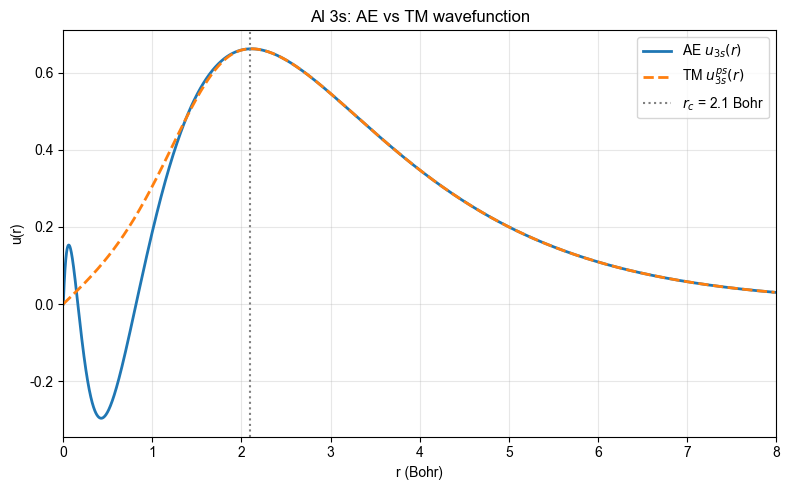

In [4]:
# 可视化 3s 通道波函数对比
fig, ax = plt.subplots(figsize=(8, 5))

r_max_plot = 8.0  # 限制绘图范围
mask = ae.r <= r_max_plot

ax.plot(ae.r[mask], ae.u_by_l[0][-1][mask], label='AE $u_{3s}(r)$', linewidth=2)
ax.plot(ae.r[mask], tm_dict[0].u_ps[mask], '--', label='TM $u_{3s}^{ps}(r)$', linewidth=2)
ax.axvline(rc_map[0], color='gray', linestyle=':', label=f'$r_c$ = {rc_map[0]} Bohr')
ax.set_xlabel('r (Bohr)')
ax.set_ylabel('u(r)')
ax.set_title('Al 3s: AE vs TM wavefunction')
ax.legend()
ax.grid(alpha=0.3)
ax.set_xlim(0, r_max_plot)

plt.tight_layout()
plt.show()


## 小结与下一步
- 赝势把平面波最昂贵的近核部分替换为平滑的 TM 伪波函数，同时保持模守恒与散射相位一致性。
- `solve_ae_atom → tm_pseudize → invert_semilocal_potential → run_full_validation` 构成最小可行流程。
- 接下来可在 `01-ae-foundation.ipynb` 深入 AtomSCF 的全电子求解，再逐个 Notebook 拆解 TM、势反演、KB、验证与幽灵态处理细节。
